<a href="https://colab.research.google.com/github/Nikelroid/DeepLearning_Project/blob/main/Phase-3/Part-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading data onto the disk

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/My Drive

/content/drive/My Drive


In [ ]:
# !ls drive/My\ Drive/

In [ ]:
# !cp train_ende.zip .
# !cp test.zip .

In [ ]:
#!git clone https://github.com/XL2248/MSCTD

In [ ]:
'''
!cp MSCTD/MSCTD_data/ende/english_*.txt .
!cp MSCTD/MSCTD_data/ende/image_index_*.txt .
!cp MSCTD/MSCTD_data/ende/sentiment_*.txt .

import os
import shutil

for file in os.listdir('MSCTD/MSCTD_data/ende'):
    if file.startswith('english_'):
        shutil.copy('MSCTD/MSCTD_data/ende/' + file, file)
    if file.startswith('image_index_'):
        shutil.copy('MSCTD/MSCTD_data/ende/' + file, file)
    if file.startswith('sentiment_'):
        shutil.copy('MSCTD/MSCTD_data/ende/' + file, file)
'''

In [ ]:
#!pip install --upgrade --no-cache-dir gdown
#!gdown --id 1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj
#!gdown --id 1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W

In [ ]:
%cd drive/MyDrive/dataset/train

In [ ]:
!ls

In [ ]:
!unzip train_ende.zip


In [ ]:
'''
%%bash
for x in *.zip
do
  unzip -qq $x
done
'''

In [ ]:
# !mkdir dataset
# !cd dataset; mkdir train test dev
'''
os.makedirs('dataset', exist_ok=True)
os.makedirs('dataset/train', exist_ok=True)
os.makedirs('dataset/test', exist_ok=True)
os.makedirs('dataset/dev', exist_ok=True)
'''

In [ ]:
# !mv *train* dataset/train
# !mv *test* dataset/test
# !mv *dev* dataset/dev
'''
for file in os.listdir():
    if 'train' in file:
        shutil.move(file, 'dataset/train')
    if 'test' in file:
        shutil.move(file, 'dataset/test')
    if 'dev' in file:
        shutil.move(file, 'dataset/dev')
'''

# Dataset and Dataloader

In [ ]:
!pip install mtcnn

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from mtcnn.mtcnn import MTCNN
import linecache

In [5]:
class MSCTD_Dataset (Dataset):
  def __init__(self, dataset_dir, images_dir, conversation_dir, texts, sentiments,
                transform=None, preprocess_func=None, pad_idx=None, max_len=None):
    self.dataset_path = Path(dataset_dir)
    self.images_path = self.dataset_path / images_dir
    self.sentiment_path = self.dataset_path / sentiments
    self.text_path = self.dataset_path / texts
    self.conversations_path = self.dataset_path / conversation_dir

    self.transform = transform

    self.preprocess_func = preprocess_func
    self.pad_idx = pad_idx
    self.max_len = max_len

    with open(self.text_path, 'r') as f:
        self.texts = f.read().splitlines()

    with open(self.sentiment_path, 'r') as f:
        self.sentiments = np.array(f.read().splitlines()).astype("int32")

    with open(self.conversations_path, 'r') as f:
        self.conversations = np.array(f.read().splitlines())
    
  def __len__(self):
        return len(self.sentiments)

  def __getitem__(self, idx):
        img_path = self.images_path / f'{idx}.jpg'
        image = Image.open(img_path)
        # image = read_image(str(img_path))
        if self.transform:
            image = self.transform(image)
       
        text = self.texts[idx].strip()

        if self.preprocess_func is not None:
            text = self.preprocess_func(text)
            if self.max_len is not None:
                text = text[:self.max_len]
            if self.pad_idx is not None:
                text = F.pad(torch.tensor(text), (0, self.max_len - len(text)), 'constant', self.pad_idx)
        
        sentiment = self.sentiments[idx]

        data_dict = {"text":text,
                     "image":image,
                     "sentiment":sentiment}
        return data_dict

In [6]:
class Final_Dataset (MSCTD_Dataset):
  def __init__(self, dataset_dir, images_dir, conversation_dir, texts, sentiments,
               preprocess_func=None, pad_idx=None, max_len=None, transform=None):

    super().__init__(dataset_dir, images_dir, conversation_dir, texts, sentiments, transform)
    self.dataset_path = Path(dataset_dir)
    self.images_path = self.dataset_path / images_dir
    self.sentiment_path = self.dataset_path / sentiments
    self.text_path = self.dataset_path / texts
    self.conversations_path = self.dataset_path / conversation_dir
    self.transform = transform
    self.preprocess_func = preprocess_func
    self.pad_idx = pad_idx
    self.max_len = max_len

    with open(self.sentiment_path, 'r') as f:
      self.length = len(f.readlines())

    with open(self.text_path, 'r') as f:
        self.texts = f.read().splitlines()

    with open(self.sentiment_path, 'r') as f:
        self.sentiments = np.array(f.read().splitlines()).astype("int32")
    
    with open(self.conversations_path, 'r') as f:
        self.conversations = np.array(f.read().splitlines())
    
  def __len__(self):
        return self.length

  def __getitem__(self, idx):
        text = self.texts[idx]
        if self.preprocess_func is not None:
            text = self.preprocess_func(text)
            if self.max_len is not None:
                text = text[:self.max_len]
            if self.pad_idx is not None:
                text = F.pad(torch.tensor(text), (0, self.max_len - len(text)), 'constant', self.pad_idx)
        labels = self.sentiments[idx]
        img_path = self.images_path / f'{idx}.jpg'
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        sentiment = self.sentiments[idx]
        return text,image,sentiment

In [ ]:
!pip install pyenchant

In [8]:
import nltk
import string
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

import enchant
english_dict = enchant.Dict("en_US")

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

In [10]:
NUM = '<NUM>'
UNK = '<UNK>'

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def sent_preprocess(sent, lower=True, remove_punct=True, remove_stopwords=True,
                    lemmatize=True, handle_nums=True, handle_unknowns=True):
    if lower:
        sent = sent.lower()
    
    if remove_punct:
        sent = sent.translate(str.maketrans('', '', string.punctuation))
    
    word_tokens = word_tokenize(sent)

    if remove_stopwords:
        word_tokens = [w for w in word_tokens if not w in stop_words]

    if lemmatize:
        word_tokens = [lemmatizer.lemmatize(w) for w in word_tokens]

    if handle_nums:
        
        def is_number(s):
            if s.isdigit():
                return True
            if s[:-2].isdigit():
                if s[-2:] == 'th' or s[-2:] == 'st' or s[-2:] == 'nd' or s[-2:] == 'rd':
                    return True
            return False

        word_tokens = [NUM if is_number(w) else w for w in word_tokens]

    if handle_unknowns:
        word_tokens = [w if english_dict.check(w) else UNK for w in word_tokens]

    return word_tokens

# Model

### Bert Congfiguration

In [ ]:
!pip install transformers

In [12]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel, AutoModel, BertForSequenceClassification
from transformers import AdamW

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
# general config
MAX_LEN = 30

TRAIN_BATCH_SIZE = 512
VALID_BATCH_SIZE = 512
TEST_BATCH_SIZE = 512

EPOCHS = 4
LEARNING_RATE = 5e-5

MODEL_NAME = 'bert-base-uncased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
config = BertConfig.from_pretrained(MODEL_NAME)

In [16]:
def bert_preprocess(text):
    return tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        padding='max_length',
        return_tensors='pt',
    )

In [17]:
# change this if needed
transform = T.Compose([T.ToTensor()])

trainset = MSCTD_Dataset('dataset/train', 'train_ende', 'image_index_train.txt', 'english_train.txt', 'sentiment_train.txt', preprocess_func=bert_preprocess, transform=transform)
devset = MSCTD_Dataset('dataset/dev', 'dev', 'image_index_dev.txt', 'english_dev.txt', 'sentiment_dev.txt', preprocess_func=bert_preprocess, transform=transform)
testset = MSCTD_Dataset('dataset/test', 'test', 'image_index_test.txt', 'english_test.txt', 'sentiment_test.txt', preprocess_func=bert_preprocess, transform=transform)

In [18]:
train_loader = DataLoader(trainset, batch_size=32, shuffle=False)
dev_loader = DataLoader(devset, batch_size=32, shuffle=False)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

# Get and save embedding of models

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [20]:
transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Resize((288,288),transforms.InterpolationMode("bicubic"))
                                ,transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])     
def bert_preprocess(text):
    return tokenizer.encode_plus(
        text,
        max_length= MAX_LEN,
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        padding='max_length',
        return_tensors='pt',
    )
train_dataset = Final_Dataset('dataset/train', 'train_ende', 'image_index_train.txt', 'english_train.txt', 'sentiment_train.txt',preprocess_func=bert_preprocess,transform=transform)
dev_dataset = Final_Dataset('dataset/dev', 'dev', 'image_index_dev.txt', 'english_dev.txt', 'sentiment_dev.txt',preprocess_func=bert_preprocess,transform=transform)
test_dataset = Final_Dataset('dataset/test', 'test', 'image_index_test.txt', 'english_test.txt', 'sentiment_test.txt',preprocess_func=bert_preprocess,transform=transform)

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=VALID_BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

In [ ]:
#!pip install --upgrade --no-cache-dir gdown
#!gdown 11caq-CNLP6_V3106zj0zAkFyYPAjyjyw

!pip install transformers
from transformers import BertForSequenceClassification

def load_pretrained_bert(name='models/bert_model.pt'):
    model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
        num_labels = 3,
        output_attentions = False,
        output_hidden_states = False,
    ).to(device)
    model.load_state_dict(torch.load(name))
    model.classifier = nn.Sequential()
    return model

In [23]:
#!pip install --upgrade --no-cache-dir gdown
#!gdown 1EfyDFNxAHGjvnLPRbP0SfnkV9g33-CFJ

from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

def load_pretrained_image(name = 'models/scene_modal_en.pth'):
    class lastLayer(nn.Module):
      def __init__(self, pretrained):
          super(lastLayer, self).__init__()
          self.pretrained = pretrained
          self.last = nn.Sequential(
              nn.Dropout(p = 0.2,inplace=True),
              nn.Linear(1408, 90),
              nn.Dropout(p = 0.3,inplace=True),
              nn.Linear(90, 30),
              nn.Dropout(p = 0.1,inplace=True),
              nn.Linear(30, 3),
              )
      
      def forward(self, x):
          x = self.pretrained(x)
          x = self.last(x)
          return x

    image_model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
    image_model.classifier = nn.Sequential()
    image_model = lastLayer(image_model).to(device)
    image_model.load_state_dict(torch.load("models/scene_modal_en.pth"))
    image_model.last = nn.Sequential()
    return image_model

In [ ]:
image_model = load_pretrained_image()
text_model = load_pretrained_bert()


In [ ]:
#!mkdir dataset/train/cated_data

In [ ]:
'''
import tqdm
import pickle

vectors = []
labels = []
with tqdm.tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
      with torch.no_grad():  
        for i, m in pbar:
            data_i,image_i, y = m
            (input_ids, attention_mask, token_type_ids) = data_i.values()
            input_ids, attention_mask, token_type_ids = input_ids.to(device), attention_mask.to(device), token_type_ids.to(device)
            y = y.to(device)
            input_ids = input_ids.squeeze(1)
            attention_mask = attention_mask.squeeze(1)
            token_type_ids = token_type_ids.squeeze(1)
            output = text_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            rep_text = output.logits
            y = y.to(device)
            image_i = image_i.to(device)
            rep_image = image_model(image_i)
            rep = torch.cat((rep_text,rep_image),dim=1)
            print(rep.size())
            print(y.size())
            torch.save(y, "dataset/train/cated_data/labels_"+str(i)+".pt") 
            torch.save(rep, "dataset/train/cated_data/vectors_"+str(i)+".pt") 
'''

In [25]:
#!mkdir dataset/test/cated_data

In [ ]:
'''
import tqdm
import pickle

vectors = []
labels = []
with tqdm.tqdm(enumerate(test_loader), total=len(test_loader)) as pbar:
      with torch.no_grad():  
        for i, m in pbar:
            data_i,image_i, y = m
            (input_ids, attention_mask, token_type_ids) = data_i.values()
            input_ids, attention_mask, token_type_ids = input_ids.to(device), attention_mask.to(device), token_type_ids.to(device)
            y = y.to(device)
            input_ids = input_ids.squeeze(1)
            attention_mask = attention_mask.squeeze(1)
            token_type_ids = token_type_ids.squeeze(1)
            output = text_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            rep_text = output.logits
            y = y.to(device)
            image_i = image_i.to(device)
            rep_image = image_model(image_i)
            rep = torch.cat((rep_text,rep_image),dim=1)
            print(rep.size())
            print(y.size())
            torch.save(y, "dataset/test/cated_data/labels_"+str(i)+".pt") 
            torch.save(rep, "dataset/test/cated_data/vectors_"+str(i)+".pt") 
'''

In [38]:
image_lenght = int(len([name for name in os.listdir("dataset/train/cated_data") if os.path.isfile(os.path.join("dataset/train/cated_data", name))])/2)
data_train = torch.load("dataset/train/cated_data/vectors_"+str(0)+".pt")
labels_train = torch.load("dataset/train/cated_data/labels_"+str(0)+".pt")
for i in range(1,image_lenght):
  t = torch.load("dataset/train/cated_data/vectors_"+str(i)+".pt")
  lb = torch.load("dataset/train/cated_data/labels_"+str(i)+".pt")
  data_train = torch.cat((data_train,t),dim=0)
  labels_train = torch.cat((labels_train,lb),dim=0)

In [39]:
data_train.size()

torch.Size([20240, 2176])

In [41]:
labels_train.size()

torch.Size([20240])

In [145]:
image_lenght = int(len([name for name in os.listdir("dataset/test/cated_data") if os.path.isfile(os.path.join("dataset/test/cated_data", name))])/2)
data_test = torch.load("dataset/test/cated_data/vectors_"+str(0)+".pt")
labels_test = torch.load("dataset/test/cated_data/labels_"+str(0)+".pt")
for i in range(1,image_lenght):
  t = torch.load("dataset/test/cated_data/vectors_"+str(i)+".pt")
  lb = torch.load("dataset/test/cated_data/labels_"+str(i)+".pt")
  data_test = torch.cat((data_test,t),dim=0)
  labels_test = torch.cat((labels_test,lb),dim=0)

In [47]:
data_test.size()

torch.Size([5067, 2176])

In [146]:
labels_test

tensor([1, 1, 2,  ..., 2, 1, 2], device='cuda:0', dtype=torch.int32)

### Model Architecture

In [189]:
import torch.nn.functional as F
class MultiModalModel(nn.Module):
        def __init__(self,num_input,num_classes=3):
          super(MultiModalModel,self).__init__()
          hidden_1 = num_input//2
          self.fc1 = nn.Linear(num_input, hidden_1)
          self.fc2 = nn.Linear(hidden_1, num_classes)
          self.droput = nn.Dropout(0.1)

        def forward(self,x):
          x = F.relu(self.fc1(x))
          x = self.droput(x)
          x = self.fc2(x)
          return x

In [190]:
modalmodel = MultiModalModel(data_train.size()[1]).to(device)

# Training

In [89]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [90]:
import tqdm

def one_epoch(model, vector,truth, criterion, optimizer=None, train=True,batch_size = 64):
    total_loss = 0
    N = len(truth)
    Y = []
    Y_pred = []
    if train:
        model.train()
    else:
        model.eval()
    for i in (range(N//batch_size + 1)):
        vec = vector[i*batch_size:min((i+1)*batch_size,N)]
        y = truth[i*batch_size:min((i+1)*batch_size,N)]
        
        if train:
            optimizer.zero_grad()
        vec = vec.to(device)
        y = y.long().to(device)
        p = model(vec)
        loss = criterion(p, y.long())
        total_loss += loss.item() * len(y)
        if train:
            loss.backward()
            optimizer.step()
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    total_loss /= N

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy_score(Y_pred, Y)
    result = {'loss': total_loss, 'accuracy': acc}
    if metrics is not None:
        result.update({metric: metric_func(Y, Y_pred) for metric, metric_func in metrics.items()})

    return result

In [170]:
def train_model(model, train,test, num_epochs, criterion, optimizer, model_name='pytroch-model', scheduler=None,batch_size=64):
    train_loader, train_labels = train
    test_loader, test_labels = test
    min_val_acc = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        result = one_epoch(model, train_loader,train_labels, criterion, optimizer, train=True,batch_size=batch_size)
        train_loss = result['loss']
        train_acc = result['accuracy']
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_result = one_epoch(model, test_loader,test_labels, criterion, train=False,batch_size=batch_size)
        val_loss = val_result['loss']
        val_acc = val_result['accuracy']
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print()
        print(f'Train Accuracy : {train_acc*100.:2f}% , Train Loss : {train_loss:4f}')
        print(f'Valid Accuracy : {val_acc*100.:2f}% , Valid Loss : {val_loss:4f}')

        if val_acc > min_val_acc:
            min_val_acc = val_acc
            torch.save(model.state_dict(), f'{model_name}.pt')

        if scheduler:
            scheduler.step(val_loss)

    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title('Loss history of training and Val sets')
    plt.legend()
    plt.show()

    plt.plot(train_accuracies, label='train')
    plt.plot(val_accuracies, label='val')
    plt.title('Accuracy history of training and Val sets')
    plt.legend()
    plt.show()

    model.load_state_dict(torch.load(f'{model_name}.pt'))
    return model, min_val_loss

In [137]:
average_policy = 'macro'
metrics = {'accuracy': accuracy_score, 'precision': lambda y1, y2: precision_score(y1, y2, average=average_policy),
           'recall': lambda y1, y2: recall_score(y1, y2, average=average_policy),
           'f1': lambda y1, y2: f1_score(y1, y2, average=average_policy),
           'confusion_matrix': confusion_matrix}

In [ ]:
# Training Configuration
LEARNING_RATE = 1e-5
EPOCH = 30
BATCH_SIZE = 64
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, modalmodel.parameters()), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True, factor=0.5)
criterion = nn.CrossEntropyLoss()
modalmodel, min_val_loss = train_model(modalmodel, (data_train,labels_train),(data_test,labels_test),EPOCH, criterion, optimizer, model_name='multi_modal', scheduler=scheduler,batch_size =BATCH_SIZE)

# Evaluation

In [134]:
def eval_model(model, loader, metrics=metrics, set_name='Test', plot_confusion_matrix=True):
    test_loader,test_labels = loader
    results = one_epoch(modalmodel, test_loader,test_labels, criterion, train=False,batch_size=64)
    disp = ConfusionMatrixDisplay(results.pop('confusion_matrix'))
    if plot_confusion_matrix:
        disp.plot()
    return results

{'loss': 1.0308159757512125,
 'accuracy': 0.5109532267613973,
 'precision': 0.49459412570910005,
 'recall': 0.49214243052451795,
 'f1': 0.4865680397937809}

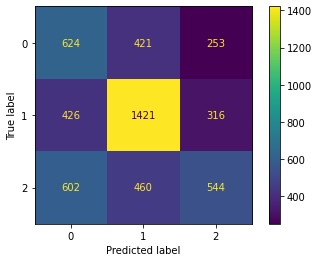

In [192]:
eval_model(modalmodel, (data_test,labels_test))